In this notebook, let's consider all the functionalities of langchain under the lense of how to be a more productive researcher.

# Leveraging Code Executionm

In [1]:
# !pip install -r requirements.txt

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema.output_parser import StrOutputParser
from langchain_experimental.utilities import PythonREPL

In [4]:
template = """Write some python code to solve the user's problem. 

Return only python code in Markdown format, e.g.:

```python
....
```"""
prompt = ChatPromptTemplate.from_messages([("system", template), ("human", "{input}")])

model = ChatOpenAI()

In [5]:
def _sanitize_output(text: str):
    _, after = text.split("```python")
    return after.split("```")[0]

In [6]:
chain = prompt | model | StrOutputParser() | _sanitize_output | PythonREPL().run

In [7]:
chain.invoke({"input": "whats 2 plus 2"})

Python REPL can execute arbitrary code. Use with caution.


'4\n'

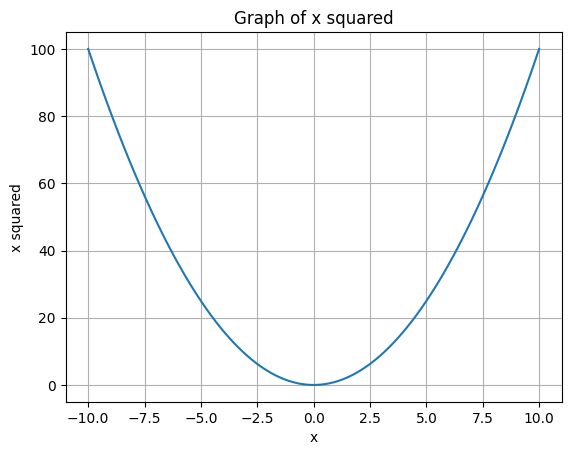

''

In [8]:
chain.invoke({"input": "Plot a graph of x squared"})

# Leveraging Tools

In [7]:
# !pip install duckduckgo-search

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.tools import DuckDuckGoSearchRun

In [10]:
search = DuckDuckGoSearchRun()

In [11]:
template = """turn the following user input into a search query for a search engine:

{input}"""
prompt = ChatPromptTemplate.from_template(template)

model = ChatOpenAI()

In [12]:
chain = prompt | model | StrOutputParser() | search

In [17]:
chain.invoke({"input": "Search the latest papers about Large Language Models"})

"A Comprehensive Overview of Large Language Models Humza Naveed, Asad Ullah Khan, Shi Qiu, Muhammad Saqib, Saeed Anwar, Muhammad Usman, Naveed Akhtar, Nick Barnes, Ajmal Mian Large Language Models (LLMs) have recently demonstrated remarkable capabilities in natural language processing tasks and beyond. Large Language Models (LLMs) have drawn a lot of attention due to their strong performance on a wide range of natural language tasks, since the release of ChatGPT in November 2022. LLMs' ability of general-purpose language understanding and generation is acquired by training billions of model's parameters on massive amounts of text data, as predicted by scaling laws \\\\cite{kaplan2020scaling ... A Survey of Large Language Models Wayne Xin Zhao, Kun Zhou, Junyi Li, Tianyi Tang, Xiaolei Wang, Yupeng Hou, Yingqian Min, Beichen Zhang, Junjie Zhang, Zican Dong, Yifan Du, Chen Yang, Yushuo Chen, Zhipeng Chen, Jinhao Jiang, Ruiyang Ren, Yifan Li, Xinyu Tang, Zikang Liu, Peiyu Liu, Jian-Yun Nie

# Extracting Structured Information with Playwright

In [13]:
# see scripts in dev-scripts-playwright-langchain.py

# Automating Literature Review with LangChain

In [19]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")

In [27]:
from langchain import hub
from langchain.agents import AgentExecutor, create_react_agent, load_tools
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0.0)
tools = load_tools(
    ["arxiv"],
)
prompt = hub.pull("hwchase17/react")

agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [30]:
agent_executor.invoke(
    {
        "input": "Latest top 3 papers about Large Language Models",
    }
)



> Entering new AgentExecutor chain...
I should use arxiv to search for the latest papers on Large Language Models
Action: arxiv
Action Input: Large Language ModelsPublished: 2023-06-12
Title: Lost in Translation: Large Language Models in Non-English Content Analysis
Authors: Gabriel Nicholas, Aliya Bhatia
Summary: In recent years, large language models (e.g., Open AI's GPT-4, Meta's LLaMa,
Google's PaLM) have become the dominant approach for building AI systems to
analyze and generate language online. However, the automated systems that
increasingly mediate our interactions online -- such as chatbots, content
moderation systems, and search engines -- are primarily designed for and work
far more effectively in English than in the world's other 7,000 languages.
Recently, researchers and technology companies have attempted to extend the
capabilities of large language models into languages other than English by
building what are called multilingual language models.
  In this paper, we ex

{'input': 'Latest top 3 papers about Large Language Models',
 'output': 'The top 3 latest papers about Large Language Models are:\n1. "Lost in Translation: Large Language Models in Non-English Content Analysis" by Gabriel Nicholas, Aliya Bhatia\n2. "How Good are Commercial Large Language Models on African Languages?" by Jessica Ojo, Kelechi Ogueji\n3. "Cedille: A large autoregressive French language model" by Martin Müller, Florian Laurent'}

To automate literature review with Langchain, you can use the PubMedRetriever and PubMedLoader modules. Here's how you can do it:

• Install the required packages:

In [31]:
!pip install xmltodict # for the PubMedRetriever module.

In [32]:
# Import the necessary modules:

from langchain.retrievers import PubMedRetriever #for the PubMedRetriever module.
from langchain.document_loaders import PubMedLoader #for the PubMedLoader module.

In [33]:
#• Create an instance of the PubMedRetriever:

retriever = PubMedRetriever()

In [34]:
# Use the PubMedRetriever to get relevant documents based on a search query:

query = "neuroplasticity"
docs = retriever.get_relevant_documents(query)
docs

[Document(page_content="Post-Traumatic Stress Disorder (PTSD) is a chronic mental disorder characterized by symptoms of panic and anxiety, depression, impaired cognitive functioning, and difficulty in social interactions. While the effect of the traditional Chinese medicine artemisinin (AR) on PTSD is unknown, its therapeutic benefits have been demonstrated by studies on models of multiple neurological disorders. This study aimed to extend such findings by investigating the effects of AR administration on a rat model of PTSD induced by a regimen of single prolonged stress (SPS). After rats were subjected to the SPS protocol, AR was administered and its impact on PTSD-like behaviors was evaluated. In the present study, rats were subjected to a multitude of behavioral tests to evaluate behaviors related to anxiety, memory function, and social interactions. The expression of hippocampal synaptic plasticity-related proteins was detected using Western blot and immunofluorescence. The ultras

In [35]:

# • Create an instance of the PubMedLoader:

loader = PubMedLoader(query)

# Load the documents using the PubMedLoader:

docs = loader.load()

In [36]:
# You can now access the loaded documents and their metadata:

docs #to access the metadata of the first document.

[Document(page_content="Post-Traumatic Stress Disorder (PTSD) is a chronic mental disorder characterized by symptoms of panic and anxiety, depression, impaired cognitive functioning, and difficulty in social interactions. While the effect of the traditional Chinese medicine artemisinin (AR) on PTSD is unknown, its therapeutic benefits have been demonstrated by studies on models of multiple neurological disorders. This study aimed to extend such findings by investigating the effects of AR administration on a rat model of PTSD induced by a regimen of single prolonged stress (SPS). After rats were subjected to the SPS protocol, AR was administered and its impact on PTSD-like behaviors was evaluated. In the present study, rats were subjected to a multitude of behavioral tests to evaluate behaviors related to anxiety, memory function, and social interactions. The expression of hippocampal synaptic plasticity-related proteins was detected using Western blot and immunofluorescence. The ultras

In [37]:
docs[0].page_content #to access the content of the first document.

#By using the PubMedRetriever and PubMedLoader modules, you can automate the process of retrieving and loading relevant literature for your literature review.

"Post-Traumatic Stress Disorder (PTSD) is a chronic mental disorder characterized by symptoms of panic and anxiety, depression, impaired cognitive functioning, and difficulty in social interactions. While the effect of the traditional Chinese medicine artemisinin (AR) on PTSD is unknown, its therapeutic benefits have been demonstrated by studies on models of multiple neurological disorders. This study aimed to extend such findings by investigating the effects of AR administration on a rat model of PTSD induced by a regimen of single prolonged stress (SPS). After rats were subjected to the SPS protocol, AR was administered and its impact on PTSD-like behaviors was evaluated. In the present study, rats were subjected to a multitude of behavioral tests to evaluate behaviors related to anxiety, memory function, and social interactions. The expression of hippocampal synaptic plasticity-related proteins was detected using Western blot and immunofluorescence. The ultrastructure of synapses wa

In [38]:
len(docs)

3

In [39]:
from langchain.tools import PubmedQueryRun

In [40]:
tool = PubmedQueryRun()

In [41]:
tool.run("chatgpt")

"Published: 2024-02-21\nTitle: AI, Machine Learning, and ChatGPT in Hypertension.\nCopyright Information: \nSummary::\nHypertension, a leading cause of cardiovascular disease and premature death, remains incompletely understood despite extensive research. Indeed, even though numerous drugs are available, achieving adequate blood pressure control remains a challenge, prompting recent interest in artificial intelligence. To promote the use of machine learning in cardiovascular medicine, this review provides a brief introduction to machine learning and reviews its notable applications in hypertension management and research, such as disease diagnosis and prognosis, treatment decisions, and omics data analysis. The challenges and limitations associated with data-driven predictive techniques are also discussed. The goal of this review is to raise awareness and encourage the hypertension research community to consider machine learning as a key component in developing innovative diagnostic an

With duck duck go search

In [42]:
import requests
from bs4 import BeautifulSoup
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains.openai_functions.extraction import create_extraction_chain_pydantic
from langchain.agents import initialize_agent, AgentType, load_tools, AgentExecutor
import pandas as pd

/var/folders/5l/y8s3fc655417629rqwgxkhx80000gn/T/ipykernel_28604/1245718030.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [44]:
def parse_html(content):
    soup = BeautifulSoup(content, 'html.parser')
    text_content_with_links = soup.get_text()
    return text_content_with_links

def fetch_web_page(url):
    response = requests.get(url)
    return parse_html(response.content)

In [49]:
tools = load_tools(["arxiv"])
prompt = hub.pull("hwchase17/react")
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [54]:
output = agent_executor.invoke({"input": "Research any 3 papers about large language models and output a json object containing title, abstract and citation, the\
    structure should be as follows: {title: ..., abstract: ..., citation: ...}. You will use the arxiv search engine to find the papers. The output should ONLY BE JSON. \n\n OUTPUT:\n\n"})



> Entering new AgentExecutor chain...
I need to search for papers on large language models on arxiv.
Action: arxiv
Action Input: large language modelsPublished: 2023-06-12
Title: Lost in Translation: Large Language Models in Non-English Content Analysis
Authors: Gabriel Nicholas, Aliya Bhatia
Summary: In recent years, large language models (e.g., Open AI's GPT-4, Meta's LLaMa,
Google's PaLM) have become the dominant approach for building AI systems to
analyze and generate language online. However, the automated systems that
increasingly mediate our interactions online -- such as chatbots, content
moderation systems, and search engines -- are primarily designed for and work
far more effectively in English than in the world's other 7,000 languages.
Recently, researchers and technology companies have attempted to extend the
capabilities of large language models into languages other than English by
building what are called multilingual language models.
  In this paper, we explain how the

In [61]:
# Define a Pydantic schema for your data (modify according to your data structure)
from langchain_core.pydantic_v1 import BaseModel

class LiteratureData(BaseModel):
    """Extracts paper information from the output of an arxiv search."""
    title: str
    abstract: str
    citation: str
    

# Create a chain to extract information based on the schema
extraction_chain = create_extraction_chain_pydantic(
    pydantic_schema=LiteratureData,
    llm=ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125"),  # specify the model you want to use
)

In [62]:
results = output["output"]
literature_data_output = extraction_chain.invoke(results)

In [68]:
df = pd.DataFrame([data.dict() for data in literature_data_output["text"]])
df.head()  # Displaying the first few rows of the DataFrame

,title,abstract,citation
0,Lost in Translation: Large Language Models in ...,"In recent years, large language models (e.g., ...","Gabriel Nicholas, Aliya Bhatia. (2023). Lost i..."
1,Cedille: A large autoregressive French languag...,Scaling up the size and training of autoregres...,"Martin Müller, Florian Laurent. (2022). Cedill..."
2,How Good are Commercial Large Language Models ...,Recent advancements in Natural Language Proces...,"Jessica Ojo, Kelechi Ogueji. (2023). How Good ..."


In [ ]:
# Alternative with create_structured_output_chain() and json_schema
# This example needs some work
# json_schema = {
#     "title": "Literature Review",
#     "description": "Structured output for a literature review",
#     "type": "object",
#     "properties":{
#             "author": {"title": "Author", "description": "Author of the paper", "type": "string"},
#             "abstract": {"title": "Abstract", "description": "Abstract of the paper", "type": "string"},
#             "citation": {"title": "Citation", "description": "Citation of the paper", "type": "string"},
#             "key_points": {"title": "Key Points", "description": "Key points of the paper if available", "type": "string"},
#             },
# "required": [],
# }

# llm = ChatOpenAI(model="gpt-4-1106-preview", temperature=0)
# prompt = ChatPromptTemplate.from_messages([("system", "You are extracting literature information in structured formats"),         ("human", "Use the given format to extract information from the following input: {input}")])

# chain = create_structured_output_chain(json_schema, llm, prompt, verbose=True)
# output = chain.run(literature_data_output)
# output
# output